In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import time
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import glob 
import cv2
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [17]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  OUTPUT_TENSOR_INSTANCE_NAME = 'InstanceCenterPredictions:0'
  OUTPUT_TENSOR_OFFSET_NAME = 'InstanceOffsetPredictions:0'
  OUTPUT_NAME_INSTANCE_SEG = 'InstanceSegmentationPredictions:0'
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, GRAPH_PB_PATH):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()
    graph_def = None
    
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    """
    t = 0
    for i in range(11):
        t1 = time.time()
        batch_seg_map, batch_instance_center, batch_instance_offset, batch_instance_seg = self.sess.run(
            [self.OUTPUT_TENSOR_NAME, self.OUTPUT_TENSOR_INSTANCE_NAME, self.OUTPUT_TENSOR_OFFSET_NAME, self.OUTPUT_NAME_INSTANCE_SEG],
            feed_dict={self.INPUT_TENSOR_NAME: image})
        t2 = time.time()
        if i > 1:
            t+=t2-t1
        print(t2-t1)
    
    
   
    print("Average : ",   t/10)
    seg_map = batch_seg_map[0]
    instance_center = batch_instance_center[0]
    instance_offset = batch_instance_offset[0]
    instance_seg = batch_instance_seg

    return seg_map, instance_center, instance_offset, instance_seg


In [149]:
from tensorflow.python.platform import gfile
MODEL = DeepLabModel("/mrtstorage/users/rehman/experiments/tmp/frozen_graph/x71frozen_graph/frozen_inference_graph_c2e_50.pb")

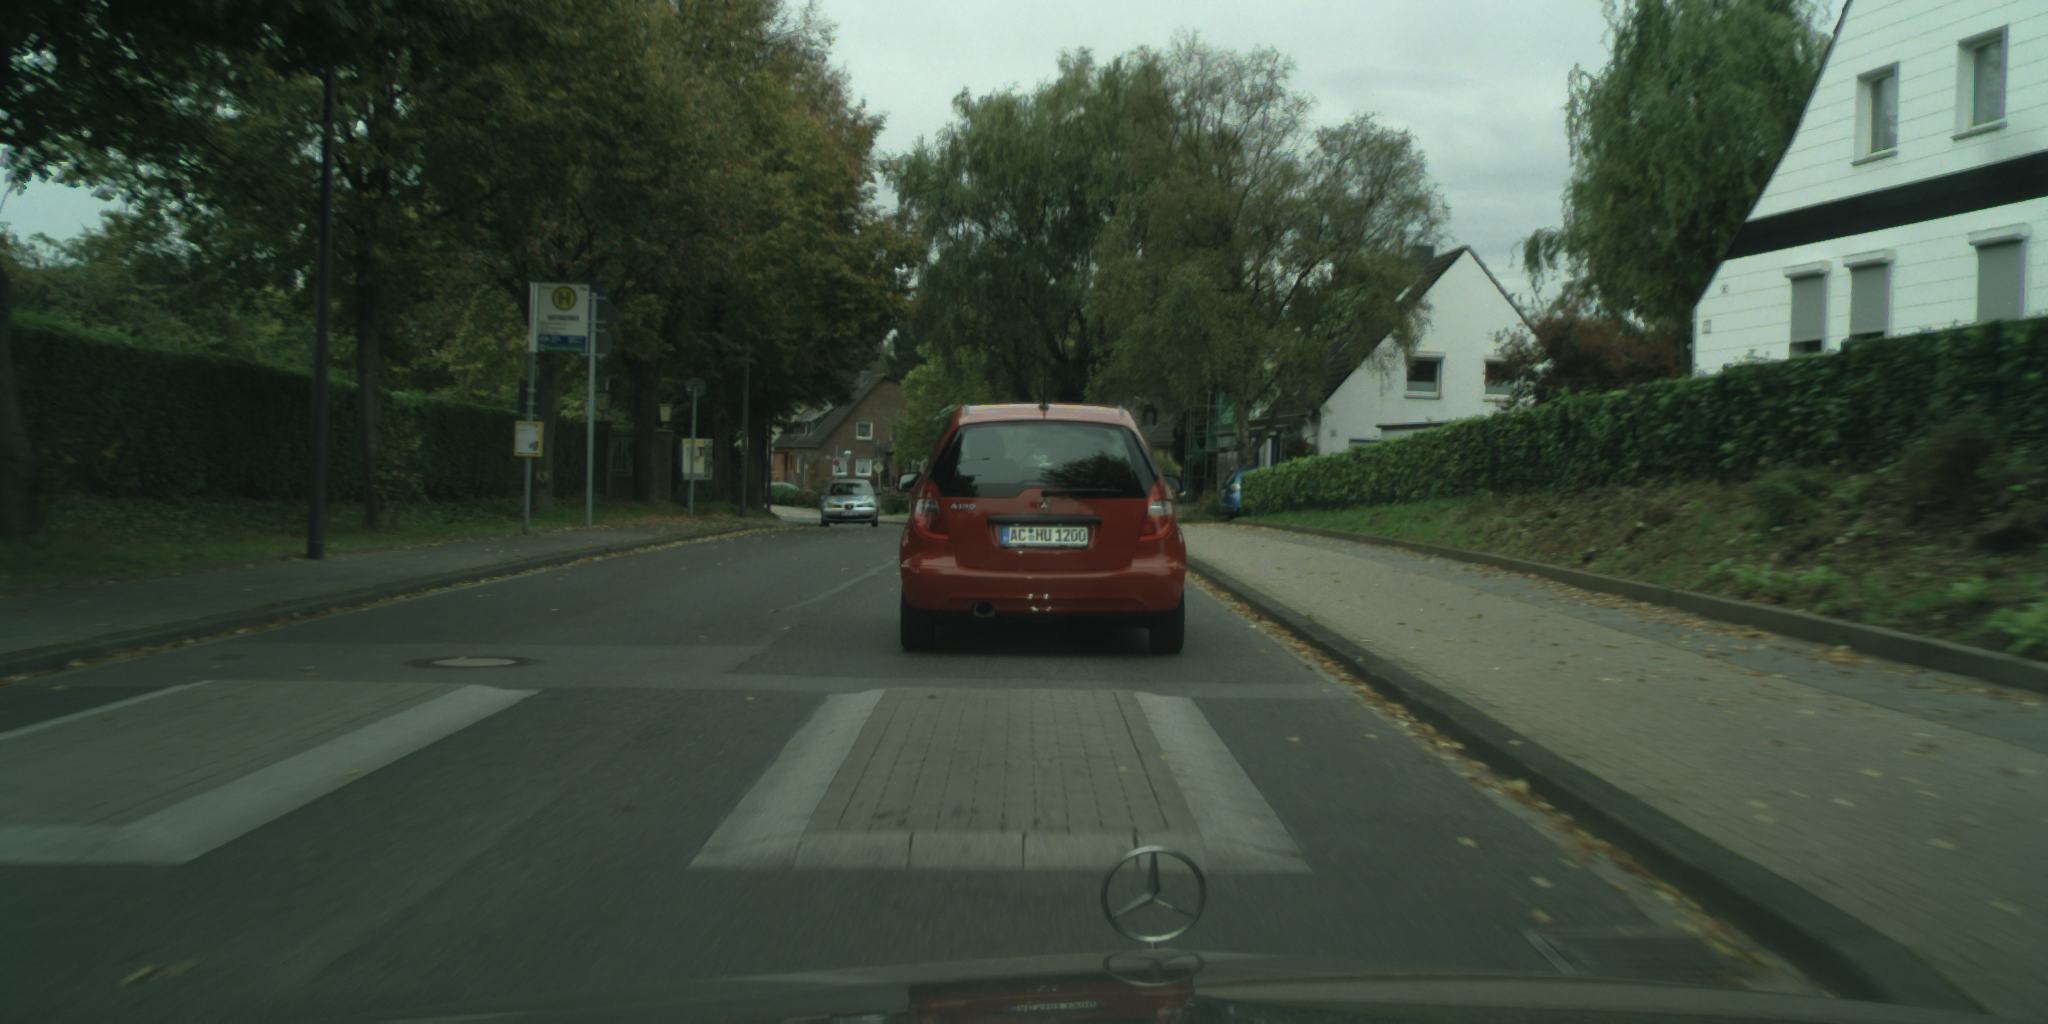

In [150]:
import glob


image_path = glob.glob('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/*.png')
# img = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')
image1 = Image.open(image_path[5])  #65
# image1 = Image.open('/mrtstorage/users/rehman/datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')  #65


image = np.expand_dims(image1, 0)
image1

In [156]:

seg_map, center_pred, pred_offset, pred_instance_seg  = MODEL.run(image)

0.302456855774
0.373161077499
0.323595046997
0.284600973129
0.290375947952
0.27233505249
0.292466878891
0.408243894577
0.312653064728
0.380024194717
0.270522117615
('Average : ', 0.2834817171096802)


[0]


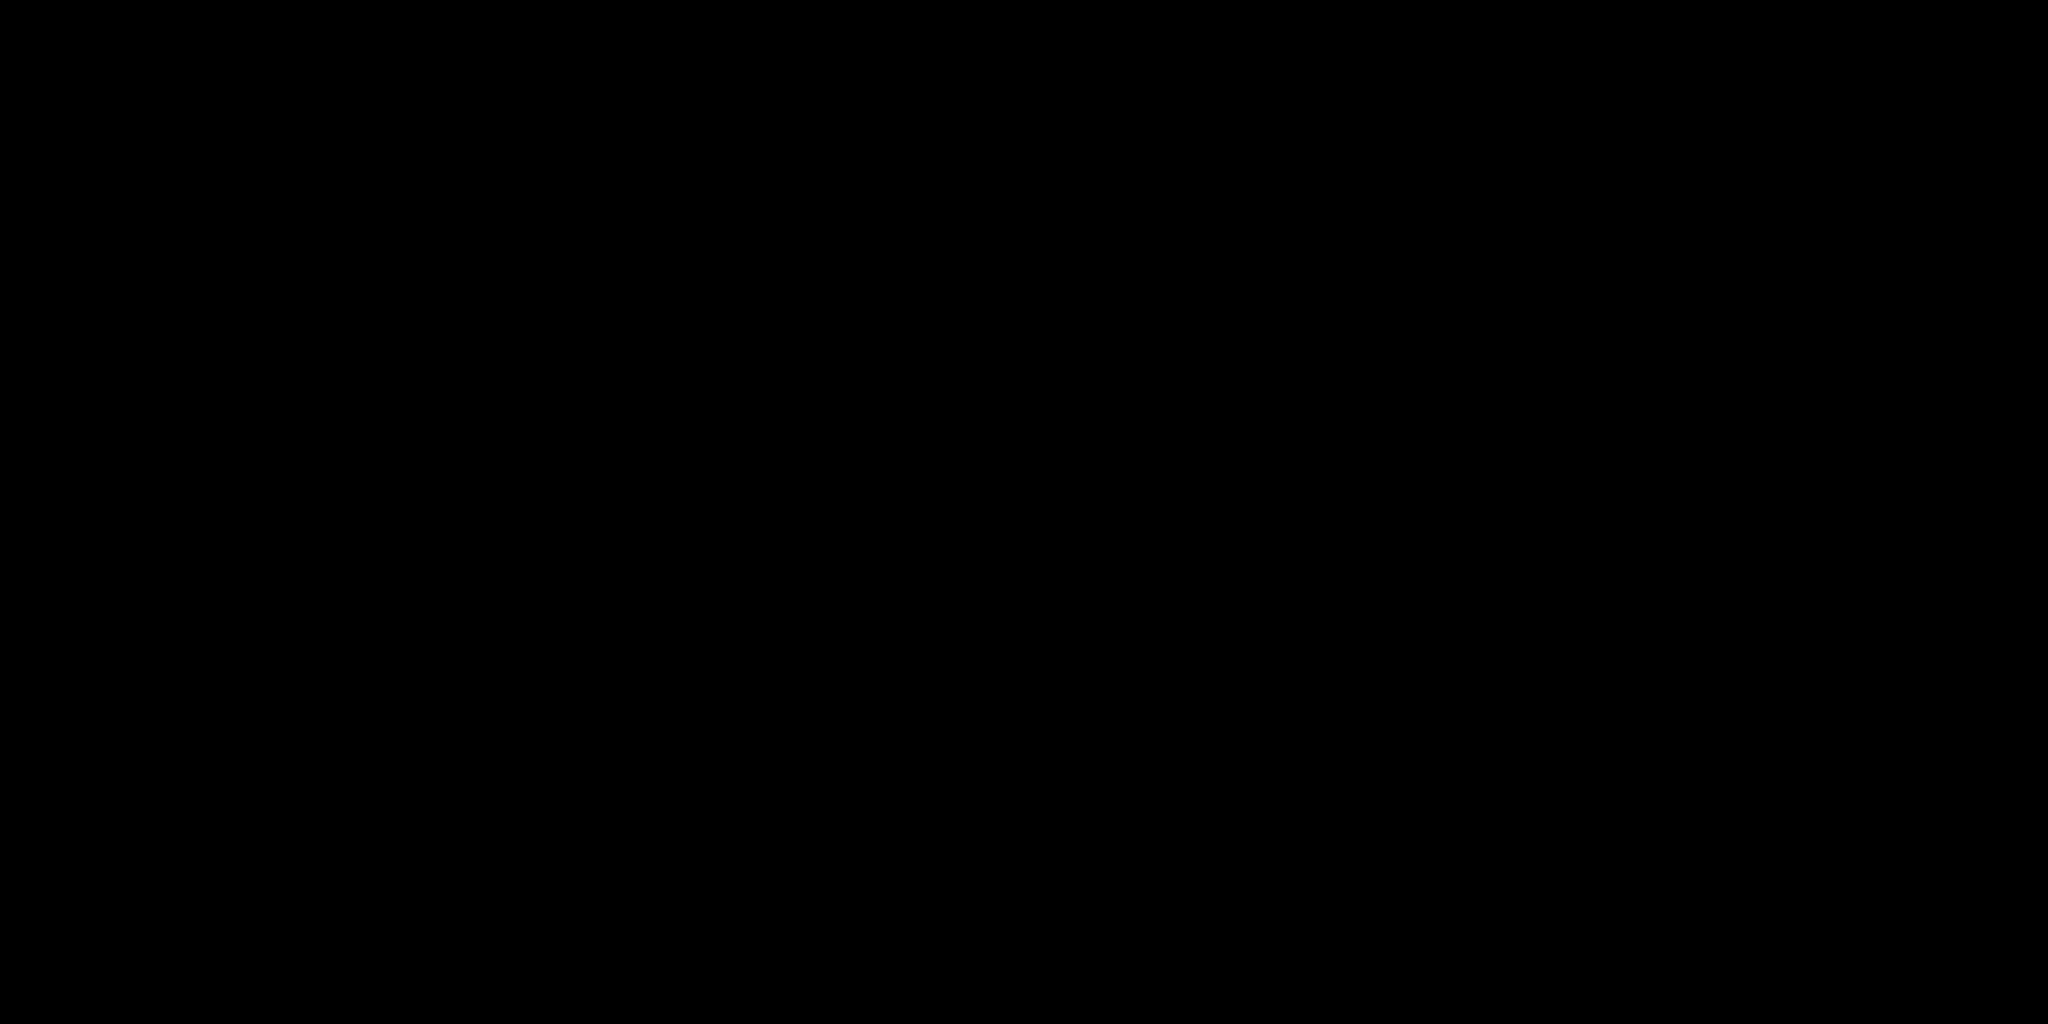

In [152]:
pred_instance_seg_uni = np.unique(pred_instance_seg)

print(pred_instance_seg_uni)

Image.fromarray(pred_instance_seg.astype(np.uint8))